## Model and Evaluation 3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yellowbrick as yb
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

player = pd.read_csv('~/7331_Lab2/data/player.csv')
playerNoSal = pd.read_csv('~/7331_Lab2/data/playerNoSal.csv')
playerScale = pd.read_csv('~/7331_Lab2/data/playerscale.csv')
playerNoSalScale = pd.read_csv('~/7331_Lab2/data/playerNoSalscale.csv')

In [2]:
player = player.drop(['Unnamed: 0'], axis=1)
playerNoSal = playerNoSal.drop(['Unnamed: 0'], axis=1)
playerScale = playerScale.drop(['Unnamed: 0'], axis=1)
playerNoSalScale = playerNoSalScale.drop(['Unnamed: 0'], axis=1)

print(player.info())
print(playerNoSal.info())
print(playerScale.info())
print(playerNoSalScale.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19820 entries, 0 to 19819
Data columns (total 43 columns):
yearID                 19820 non-null int64
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19820 non-nul

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15574 entries, 0 to 19819
Data columns (total 40 columns):
G_x               15574 non-null float64
AB                15574 non-null float64
R                 15574 non-null float64
H                 15574 non-null float64
2B                15574 non-null float64
3B                15574 non-null float64
HR                15574 non-null float64
RBI               15574 non-null float64
SB_x              15574 non-null float64
CS_x              15574 non-null float64
BB                15574 non-null float64
SO                15574 non-null float64
IBB               15574 non-null float64
HBP               15574 non-null float64
SH                15574 non-null float64
SF                15574 non-null float64
GIDP              15574 non-null float64
stint             15574 non-null float64
G_y               15574 non-null float64
GS                15574 non-null float64
InnOuts           15574 non-null float64
PO                15574 non-nu

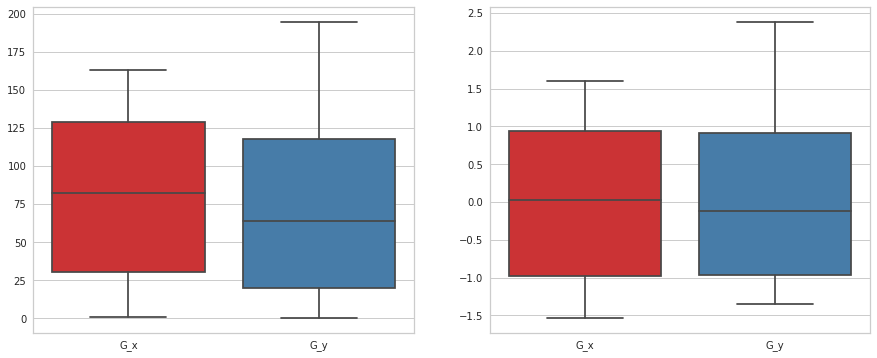

In [3]:
### Experiment with Subsetting Data
#Games
fig, ax =plt.subplots(1,2, figsize=(15,6))
sns.boxplot(data=player[['G_x', 'G_y']], palette="Set1", ax=ax[0])
sns.boxplot(data=playerScale[['G_x', 'G_y']], palette="Set1", ax=ax[1])

playerScale = playerScale[playerScale.G_x > -1.1]
print(playerScale.info())

### Linear Discriminate Analysis

INSERT INTRODUCTTION TO LDA TEXT!!!!!!!!!!!!!!!!!

Variables to vary:  
- solver = lsqr, eigen 
- n_components = 4:30:2
- shrinkage = none, auto 
- priors = priors, no priors

StratifiedKFold Cross Validation due to number large number of outfielders compared to other positions.

#### LDA Priors
The Lahman Database does not distinguish between outfielders by position (left field, center field, right field).  All outfielders are categorized as "OF".  This does make sense as outfielders often play multiple outfield positions depending upon the baseball stadium, pitcher and game situation.  However, this poses a challenge for classification as 37% of the population by position is outfielders whereas the other positions are roughly 11% of the populations.  LDA allows us to specify prior population percentages to assist with classification.  The priors are shown below.

In [4]:
df = player[['yearID', 'playerID', 'Primary']]
df = df.groupby(['Primary']).count().reset_index()
df['Pct'] = round((df.playerID / len(player)), 4)
df = df.drop(['yearID', 'playerID'], axis=1)
print(df)

myPriors = np.array(df.Pct)
print(myPriors)

  Primary     Pct
0      1B  0.1205
1      2B  0.1162
2      3B  0.1125
3       C  0.1619
4      DH  0.0143
5      OF  0.3738
6      SS  0.1008
[0.1205 0.1162 0.1125 0.1619 0.0143 0.3738 0.1008]


#### LDA Parameter Selection
GridSearchCV will be utilized to assist with parameter selection for LDA.  StratifedShuffleSplit will be the cross validation method passed to GridSearchCV.  

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, GridSearchCV, ParameterGrid
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import metrics as mt

#Create Lists to Automate LDA Model Search
#mySolv = ['lsqr', 'eigen', 'svd']
mySolv = ['lsqr', 'svd']
myNComponents = list(range(2,20,2))
myShrink = [None, 'auto']
#parms = {'n_components': [myNComponents], 'shrinkage': [myShrink], 'solver': [mySolv]}
parms = {'n_components': [myNComponents], 'solver': [mySolv]}
parmGrid = (list(ParameterGrid(parms)))
print(parmGrid)

#Create Target and Data sets
X = playerScale.drop(['Primary', 'playerID', 'yearID'], axis=1)
y = playerScale['Primary']
#yhat = np.zeros(y.shape)
yhat = np.empty(y.shape,dtype=str)
yhat2 = np.empty(y.shape,dtype=str)

#Create cross validation interator
cv = StratifiedKFold(n_splits=10)
cv2 = StratifiedShuffleSplit(y, n_iter = 10, test_size = 0.2, train_size=0.8)

#Create arrays from data frame columns as input into dataframe iterators
X = X.values
y = y.values

### Parameter Grid Search for LDA and Stratified Shuffle Split
gscv = GridSearchCV(estimator=LinearDiscriminantAnalysis(priors=myPriors), 
                   n_jobs=10, 
                   verbose=1, 
                   param_grid = parmGrid, 
                   scoring='accuracy')

for trainidx, testidx in cv2:
    X_train = X[trainidx] 
    X_test = X[testidx] 
    y_train = y[trainidx]
    y_test = y[testidx]    
    gscv.fit(X_train, y_train)
    print("GSCV CV2 LDA Accuracy:", gscv.score(X_test, y_test))
#    clf.fit(X_train, y_train)
#    print("CV2 LDA Accuracy:", clf.score(X_test, y_test))

#Create LDA Object
#clf = LinearDiscriminantAnalysis(n_components=15, priors=myPriors, shrinkage='auto', solver='lsqr') #Accur: 0.72795
#clf = LinearDiscriminantAnalysis(n_components=14, priors=myPriors, solver='svd') #Accur: 0.72866
#clf.fit(X, y)
#print("1st Pass Accuracy:", clf.score(X, y))


#### Stratified Shuffle Split
#for trainidx, testidx in cv2:
#    X_train = X[trainidx] 
#    X_test = X[testidx] 
#    y_train = y[trainidx]
#    y_test = y[testidx]    
#    clf.fit(X_train, y_train)
#    print("CV2 LDA Accuracy:", clf.score(X_test, y_test))
#
#clf.fit(X_train, y_train)
#yhat2 = clf.predict(X_test)
#total_accuracy = mt.accuracy_score(y_test, yhat2)
#print("CV2 LDA Accuracy P:", total_accuracy)

#### Stratified K Fold
#for train, test in cv.split(X, y):
#    clf.fit(X[train],y[train])
#    print("CV LDA Acc Score:", clf.score(X[test], y[test]))
#    yhat[test] = clf.predict(X[test])
#    
#total_accuracy = mt.accuracy_score(y, yhat)
#print ('CV LDA accuracy P', total_accuracy)

[{'n_components': [2, 4, 6, 8, 10, 12, 14, 16, 18], 'solver': ['lsqr', 'svd']}]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    3.0s finished


GSCV CV2 LDA Accuracy: 0.8163723916532906
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.8s


GSCV CV2 LDA Accuracy: 0.8211878009630819
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    2.8s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    3.0s finished


GSCV CV2 LDA Accuracy: 0.8237560192616372
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    2.8s finished


GSCV CV2 LDA Accuracy: 0.8112359550561797
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    3.0s finished


GSCV CV2 LDA Accuracy: 0.8150882825040129
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    2.9s finished


GSCV CV2 LDA Accuracy: 0.8070626003210273
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    3.0s finished


GSCV CV2 LDA Accuracy: 0.8240770465489566
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.8s


GSCV CV2 LDA Accuracy: 0.8260032102728732
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    3.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    3.0s finished


GSCV CV2 LDA Accuracy: 0.8131621187800963
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s


GSCV CV2 LDA Accuracy: 0.8077046548956661


[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed:    3.0s finished


As shown below, the optimal LDA model identified by GridSearchCV is two components with least squares regression.  

In [6]:
print("Best Estimator:", gscv.best_estimator_)
print("Best Parameters:", gscv.best_params_)
print("Best Score:", gscv.best_score_)

Best Estimator: LinearDiscriminantAnalysis(n_components=2,
              priors=array([0.1205, 0.1162, 0.1125, 0.1619, 0.0143, 0.3738, 0.1008]),
              shrinkage=None, solver='lsqr', store_covariance=False,
              tol=0.0001)
Best Parameters: {'n_components': 2, 'solver': 'lsqr'}
Best Score: 0.8176418653182438


#### LDA:  Fit and Predict Using Best Estimators
With minimal training, the LDA model produces good results.  As expected,  second basemen and short stops are difficult to classify.  While not necessarily interchangeable, players at these two positions do have similar traits.  Traditionally, players at this position are prized for their defensive abilities and are allowed to be below average hitters as teams like to be sound defensively "up the middle" of the field.  The Confusion Matrix heatmap offers a visual view showing how players were classified compared the their actual positions.  

             precision    recall  f1-score   support

         1B       0.97      0.71      0.82       387
         2B       0.60      0.63      0.61       366
         3B       0.69      0.77      0.73       363
          C       1.00      0.89      0.94       453
         DH       0.77      1.00      0.87        17
         OF       0.83      0.96      0.89      1203
         SS       0.71      0.46      0.56       326

avg / total       0.81      0.81      0.80      3115



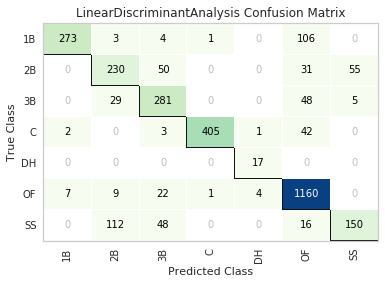

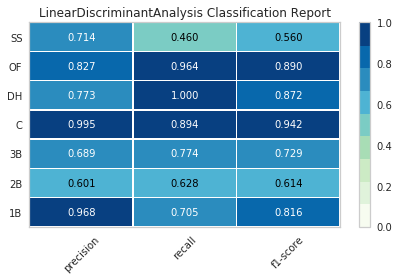

In [9]:
#Create LDA Object
clf = LinearDiscriminantAnalysis(n_components=2, priors=myPriors, solver='lsqr')

clf.fit(X_train, y_train)
yhat2 = clf.predict(X_test)

print(mt.classification_report(y_test, yhat2, target_names = ['1B', '2B', '3B', 'C', 'DH', 'OF', 'SS']))

#Create Classification Visualizations
#fig, ax =plt.subplots(1,2, figsize=(15,6))

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
cm2 = ConfusionMatrix(clf, classes=['1B', '2B', '3B', 'C', 'DH', 'OF', 'SS'], cmap='GnBu')
cm2.fit(X_train, y_train)
cm2.score(X_test, y_test)
cm2.poof()

crpt = ClassificationReport(clf, classes=['1B', '2B', '3B', 'C', 'DH', 'OF', 'SS'], cmap='GnBu')
crpt.fit(X_train, y_train)
crpt.score(X_test, y_test)
crpt.poof()

#roc = ROCAUC(clf)
#roc.fit(X_train, y_train)
#roc.score(X_test, y_test)
#roc.poof()